<div class="alert alert-block alert-info">
<center> <h1>  ABCDEats Inc.
</h1> I. PREPROCESSING </center> <br>
<center> Customer Segmentation - Part 2 </center> <br>
<center> Data Mining </center> <br>
<center> Hugo Fonseca, number: 20240520 </center>
<center> Jéssica Vicente, number: 20230744 </center>
<center> Ricardo Pereira, number: 20240745 </center> <br>
<center>Group 99 </center>

# 1. Libraries and Created Functions

In [552]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import rankdata

import warnings
warnings.filterwarnings('ignore')

In [553]:
    # 2.1. FONT 
# from matplotlib.font_manager import fontManager, FontProperties
# path = "/path/to/calibri.ttf"
# fontManager.addfont(path)


    # 2.2. TEMPLATE


def set_matplotlib_style(font_size=8):
        # Replicates the rcParams of seaborn's "whitegrid" 
        plt.style.use("seaborn-v0_8-whitegrid")

        base_style = {
            # Use 10pt font in plots, to match 10pt font in document
            "axes.labelsize": (10 / 8) * font_size,
            "font.size": (10 / 8) * font_size,
            # Make the legend/label fonts a little smaller
            "legend.fontsize": font_size,
            "xtick.labelsize": font_size,
            "ytick.labelsize": font_size,
            # Subplots size/shape
            "figure.subplot.left": 0.098,
            "figure.subplot.right": 0.938,
            "figure.subplot.bottom": 0.12,
            "figure.subplot.top": 0.944,
            "figure.subplot.wspace": 0.071,
                    }
        
        return base_style

plt.rcParams.update(set_matplotlib_style(font_size=8))


In [554]:

def replace_outliers_with_random(data):


    data = np.array(data)
    q1 = np.percentile(data, 25)  
    q3 = np.percentile(data, 75)  
    iqr = q3 - q1                 
    lower_bound = q1 - 2.5 * iqr  
    upper_bound = q3 + 2.5 * iqr  
    
    
    p5 = np.percentile(data, 5)
    p10 = np.percentile(data, 10)
    p90 = np.percentile(data, 90)
    p95 = np.percentile(data, 95)
    
    
    result = data.copy()
    lower_bound_outliers = (data < lower_bound)
    upper_bound_outliers = (data > upper_bound)
    
    result[lower_bound_outliers] = np.random.uniform(p5, p10, size=lower_bound_outliers.sum())
    result[upper_bound_outliers] = np.random.uniform(p90, p95, size=upper_bound_outliers.sum())
    
    return result

In [555]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def dbscan_diagnostics(data, features, target_noise_share=0.05, eps_range=dict(l_bound=0.01, u_bound=0.4, n_iter=20)):
    """
    Perform DBSCAN diagnostics and plot results.

    Parameters:
    - data: DataFrame containing the dataset.
    - features: List of column names to use for clustering (should be standardized).
    """
    
    eps_values = np.linspace(eps_range['l_bound'], eps_range['u_bound'], eps_range['n_iter'])
    
    
    share_all_clusters = []
    share_largest_component = []
    share_noise = []
    num_clusters = []
    
    
    for eps in eps_values:
    
        dbscan = DBSCAN(eps=eps, min_samples=2*len(features)).fit(data[features])
        labels = dbscan.labels_
        
    
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_share = np.sum(labels == -1) / len(labels)
        cluster_shares = [np.sum(labels == label) / len(labels) for label in set(labels) if label != -1]
        largest_share = max(cluster_shares) if cluster_shares else 0
        
    
        share_all_clusters.append(1 - noise_share)
        share_largest_component.append(largest_share)
        share_noise.append(noise_share)
        num_clusters.append(n_clusters)
    
    
    eps_below_x_percent_noise = next((eps for eps, noise in zip(eps_values, share_noise) if noise < target_noise_share), None)
    
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot (a)
    axs[0].plot(eps_values, share_all_clusters, label="All clusters", color='grey', marker='+', markersize=5, linewidth=0.5)
    axs[0].plot(eps_values, share_largest_component, label="Largest component", color="blue", marker='x', markersize=5, linewidth=0.4)
    axs[0].plot(eps_values, share_noise, label="Noise", color="red", marker='*', markersize=5, linewidth=0.4)
    if eps_below_x_percent_noise is not None:
        axs[0].axvline(x=eps_below_x_percent_noise, color="grey", linestyle="--", linewidth=0.6, label="Noise = {}%".format(str(int(target_noise_share*100))))
    
    axs[0].set_xlabel("Epsilon")
    axs[0].set_ylabel("Share of dataset")
    axs[0].legend()
    axs[0].set_title("(a) Cluster and component sizes")

    # Plot (b)
    axs[1].plot(eps_values, num_clusters, label="Number of clusters", color="black", linestyle="-", linewidth=0.5)
    if eps_below_x_percent_noise is not None:
        axs[1].axvline(x=eps_below_x_percent_noise, color="grey", linestyle="--", linewidth=0.6, label="Noise = {}%".format(str(int(target_noise_share*100))))
    axs[1].set_xlabel("Epsilon")
    axs[1].set_ylabel("Number of clusters")
    axs[1].legend()
    axs[1].set_title("(b) Number of clusters")
    
    
    plt.tight_layout()
    plt.show()
    
    print("The epsilon which makes noise " + str(round(target_noise_share*100, 0)) + "% of the data set is approximately: " + str(round(eps_below_x_percent_noise, 4)))
    
    return round(eps_below_x_percent_noise, 6)

In [599]:
def iforest_diagnostics(data, features, choice_of_estimators=None):


    rng = np.random.default_rng(seed=2825043)
    
    inlier_scores = []
    outlier_scores = []
    n_estimators_list = np.logspace(0.3, 3, num=50, base=10, dtype=int)

    
    initial_iforest = IsolationForest(n_estimators=100, random_state=42, contamination=0.1)
    initial_iforest.fit(data[features])
    initial_labels = initial_iforest.predict(data[features])

    
    inlier_indices = np.where(initial_labels == 1)[0]
    outlier_indices = np.where(initial_labels == -1)[0]
    sampled_inliers = rng.choice(inlier_indices, 50, replace=False)
    sampled_outliers = rng.choice(outlier_indices, 50, replace=False)

    
    for n_estimators in n_estimators_list:
        iforest = IsolationForest(n_estimators=n_estimators, random_state=42, contamination=0.1)
        iforest.fit(data[features])
        scores = iforest.decision_function(data[features]) 

    
        inlier_scores.append(np.mean(scores[sampled_inliers]))
        outlier_scores.append(np.mean(scores[sampled_outliers]))

    
    inlier_asymptote = inlier_scores[-1]
    outlier_asymptote = outlier_scores[-1]

    
    plt.figure(figsize=(4, 4))
    plt.plot(n_estimators_list, inlier_scores, label=r"$X_i$ (Inliers)", color="black", linewidth=1.0)
    plt.plot(n_estimators_list, outlier_scores, label=r"$X_o$ (Outliers)", color="black", linestyle="dotted", linewidth=1.0)

    # asymptotes
    plt.axhline(y=inlier_asymptote, color="gray", linestyle="--", linewidth=0.8, alpha=0.6, label="Inliers Asymptote")
    plt.axhline(y=outlier_asymptote, color="gray", linestyle="--", linewidth=0.8, alpha=0.6, label="Outliers Asymptote")

    # chosen number of estimators plot
    if choice_of_estimators is not None:
        plt.axvline(
            x=choice_of_estimators,
            color="green",
            linestyle="--",
            linewidth=0.4, 
            alpha=0.7,
            label=f"Chosen Estimators: {choice_of_estimators}",
        )

    plt.xscale("log")
    plt.xlabel("Number of Trees")
    plt.ylabel("Anomaly Score")
    plt.title("Convergence of the Anomaly Scores")
    plt.legend()
    plt.grid()
    plt.show()
    
    return choice_of_estimators

In [600]:
def dbscan_outliers(data, features, epsilon, outlier_column_label):
    
    dbscan = DBSCAN(
        eps=epsilon,
        min_samples= 2 * len(features)
        ).fit(X=data.loc[data[outlier_column_label] != -1, features])
    
    return np.array([-1 if label == -1 else 1 for label in dbscan.labels_])


def iforest_outliers(data, features, chosen_n_trees, samplesize=0.002, contamination=0.1111):
    
    iforest = IsolationForest(
        n_estimators=chosen_n_trees,
        contamination=contamination,
        max_samples=samplesize
    )
    
    iforest.fit(data[features])

    
    labels = iforest.predict(data[features])

    
    return np.array([-1 if label == -1 else 1 for label in labels])






def multivariate_outliers_clean(data, features, outlier_column_label, dbscan_kws, iforest_kws):
    """
    Identifies and cleans multivariate outliers using a combination of DBSCAN and Isolation Forest.
    
    Parameters:
        data (pd.DataFrame): The dataset containing the features for outlier detection.
        features (list): The list of column names to use for outlier detection.
        outlier_column_label (str): The column label to store the combined outlier results.
        dbscan_kws (dict): Dictionary with DBSCAN parameters, e.g., {'epsilon': 0.5}.
        iforest_kws (dict): Dictionary with Isolation Forest parameters, e.g., 
                            {'chosen_n_trees': 100, 'samplesize': 0.002, 'contamination': 0.1}.
                            
    Returns:
        pd.DataFrame: The input dataframe with an additional column for outlier detection.
    """
    
    
    if outlier_column_label not in data.columns:
        data[outlier_column_label] = 0
    
    
    dbscan_labels = dbscan_outliers(
        data=data.loc[ data[outlier_column_label] != -1 ], 
        features=features, 
        epsilon=dbscan_kws['epsilon'], 
        outlier_column_label=outlier_column_label
    )
    data.loc[data[outlier_column_label] != -1 , outlier_column_label] = dbscan_labels 
    
    
    non_outlier_data = data.loc[data[outlier_column_label] != -1, features]
    
    
    iforest_labels = iforest_outliers(
        data=non_outlier_data, 
        features=features, 
        chosen_n_trees=iforest_kws['chosen_n_trees'], 
        samplesize=iforest_kws.get('samplesize', 0.002), 
        contamination=iforest_kws.get('contamination', 0.1111)
    )
    
    
    data.loc[data[outlier_column_label] != -1, outlier_column_label] = iforest_labels
    
    return data

    
    
    

In [603]:
# (Not used, but was fun to try)

def pca_results(trained_model):
    explained_variance = trained_model.explained_variance_
    explained_variance_ratio = trained_model.explained_variance_ratio_
    cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
    
    pca_results = pd.DataFrame(
    {
        "Eigenvalue": explained_variance,
        "Difference": np.insert(np.diff(explained_variance), 0, 0),
        "Proportion": explained_variance_ratio,
        "Cumulative": cumulative_explained_variance_ratio
    },
        index=range(1, trained_model.n_components_ + 1)
    )
    
    return pca_results    


# (Not used, but wanted to and was fun to try)

def kernel_pca_results(trained_model):
    total_variance = trained_model.eigenvalues_.sum()
    explained_variance = trained_model.eigenvalues_
    explained_variance_ratio = explained_variance/total_variance
    cumulative_explained_variance_ratio = np.array(list(explained_variance_ratio[:i+1].sum() for i in range(len(explained_variance_ratio))))
    pca_results = pd.DataFrame(
    {
        "Eigenvalue": explained_variance,
        "Difference": np.insert(np.diff(explained_variance), 0, 0),
        "Proportion": explained_variance_ratio,
        "Cumulative": cumulative_explained_variance_ratio
    },
        index=range(1, trained_model.n_features_in_ + 1)
    )
    
    return pca_results



    

# 2. Data Import

In [559]:
with open("DM2425_ABCDEats_DATASET.csv", 'r') as file:
    raw_data = pd.read_csv(filepath_or_buffer=file, sep=',')
    
raw_data.columns

Index(['customer_id', 'customer_region', 'customer_age', 'vendor_count',
       'product_count', 'is_chain', 'first_order', 'last_order', 'last_promo',
       'payment_method', 'CUI_American', 'CUI_Asian', 'CUI_Beverages',
       'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts',
       'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese',
       'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks',
       'CUI_Thai', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5',
       'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7',
       'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15',
       'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23'],
      dtype='object')

# 3. Preprocessing

In [560]:
categorical_features = raw_data.select_dtypes(include='object').columns.to_list()
numerical_features = raw_data.drop(categorical_features, axis=1).columns.to_list()

demographic_features = numerical_features[:4]
cui_features = [feat for feat in numerical_features if "CUI" in feat]
dow_features = [feat for feat in numerical_features if "DOW" in feat]
hr_features = [feat for feat in numerical_features if "HR" in feat]

## 3.1 Categoricals

## 3.1. Handling Data Quality Issues

We drop duplicated customer_id entries

In [561]:
df_1 = raw_data.copy()
duplicated_customer_id_indexes = df_1[df_1['customer_id'].duplicated(keep='first')].index 
print(len(duplicated_customer_id_indexes))
df_1.drop(duplicated_customer_id_indexes, inplace=True)
df_1.drop('customer_id', axis=1, inplace=True)

13


We fill age null values with median

In [562]:
age_q1 = df_1.customer_age.quantile(0.25)
age_q3 = df_1.customer_age.quantile(0.75)

null_values_age = df_1['customer_age'].isna()
print(null_values_age.sum())


rng = np.random.default_rng(seed=2825043)
df_1.loc[null_values_age, 'customer_age'] = rng.uniform(age_q1, age_q3, size=null_values_age.sum()).astype(int)

727


We fill misssing values in first_order with 0s

In [563]:
null_values_first_order = df_1['first_order'].isna()
print(df_1.loc[null_values_first_order][dow_features].sum(axis=1).value_counts())
df_1.loc[null_values_first_order, 'first_order'] = 0


1    104
2      2
Name: count, dtype: int64


In [564]:
df_1.loc[null_values_first_order]['last_order'].value_counts()

last_order
0    106
Name: count, dtype: int64

We compute HR_0

In [565]:
df_1['HR_0'] = df_1[dow_features].sum(axis=1) - df_1[hr_features[1:]].sum(axis=1)

In [566]:
for feature in ['customer_age', 'vendor_count', 'product_count', 'is_chain', 'first_order', 'last_order']:
    df_1[feature] = replace_outliers_with_random(df_1[feature])

## 3.2. Preprocessing

We relabel customer regions from A - the most populated area - to H, the least populated area

In [567]:
df_2 = df_1.copy()

replace_region = {'8670': 'A',
                  '4660': 'B',
                  '2360': 'C',
                  '2440': 'D',
                  '4140': 'E',
                  '8370': 'F',
                  '2490':'G',
                  '-': '-',
                  '8550': 'H'}


df_2['customer_region'] = df_1['customer_region'].map(replace_region)
df_2['customer_region'].value_counts()

customer_region
A    9761
B    9550
C    8829
D    1483
E     857
F     495
G     445
-     442
H      13
Name: count, dtype: int64

We make customer age a categorical by grouping it by quartile 0-1, quartile 1-3, and quartile 3-4

In [568]:
df_3 = df_2.copy()

bins_age = [df_3['customer_age'].quantile(i/4) for i in range(5)]
bin_age_labels = [str(int(bins_age[i])) + '-' + str(int(bins_age[i+1])) for i in range(len(bins_age)-1)]
df_3['customer_age_binned'] = pd.cut(df_2['customer_age'], bins_age, labels=bin_age_labels)
df_3['customer_age_binned'].fillna(df_3['customer_age_binned'].mode()[0], inplace=True)



numerical_features_1 = [i for i in numerical_features if 'customer_age' not in i]
demographic_features_1 = [i for i in demographic_features if 'customer_age' not in i]
categorical_features.append('customer_age_binned')

In [596]:
df_7['customer_age']

0        18.0
1        17.0
2        38.0
3        23.0
4        20.0
         ... 
31883    30.0
31884    24.0
31885    24.0
31886    34.0
31887    30.0
Name: customer_age, Length: 31875, dtype: float64

## 3.2 Numericals

### 3.2.1 RFM clustering : Recency (lifetime), Frequency & Monetary value

In [569]:
df_4 = df_3.copy()


df_4['lifetime'] = (df_4['last_order']-df_4['first_order']).fillna(value=0)
df_4['frequency'] = df_4[hr_features].sum(axis=1)
df_4['monetary_value'] = df_4[cui_features].sum(axis=1)

rfm_feats = ['lifetime', 'frequency', 'monetary_value']

In [570]:
df_5 = df_4.copy()

#### 3.2.1.1. RFM Treatment 1: Barely any, but standardize

We create treatment 1 dataframe. We assume clients who consumed once as outliers and leave them for a later analysis. We standardize it.

In [571]:
rfm_feats_treatment_1 = [i + '_treatment_1' for i in rfm_feats]

df_5[rfm_feats_treatment_1] = StandardScaler().fit_transform( df_5[rfm_feats] )


df_5['rfm_feats_treatment_1_outliers'] = 0 # We create the column for the outlier labels

df_5.loc[  df_5['lifetime_treatment_1'] == df_5['lifetime_treatment_1'].min(), 'rfm_feats_treatment_1_outliers'] = -1 # We manually classify clients who consumed once as outliers to avoid centroid deviating too much towards this sporadic customers

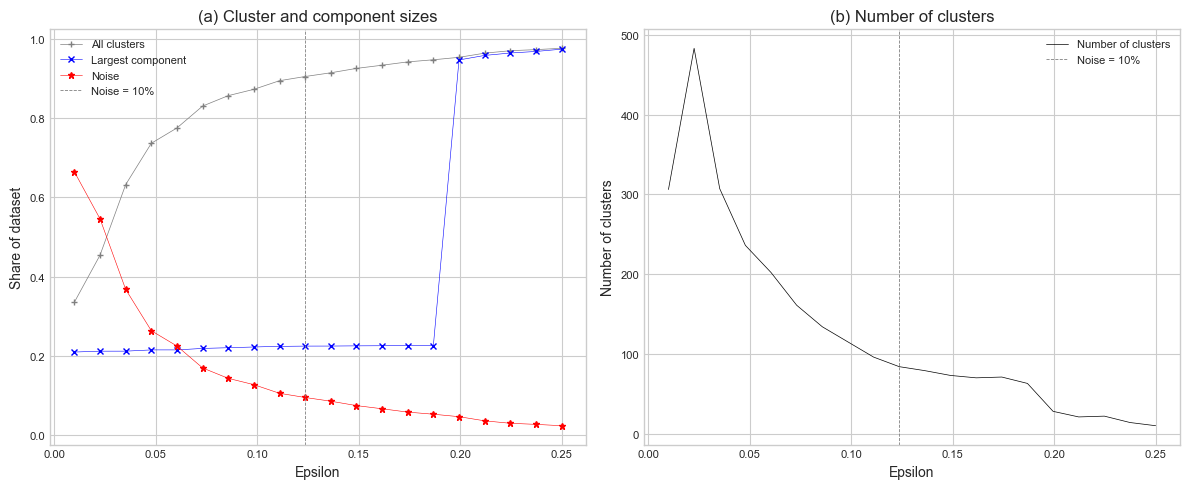

The epsilon which makes noise 10.0% of the data set is approximately: 0.1237


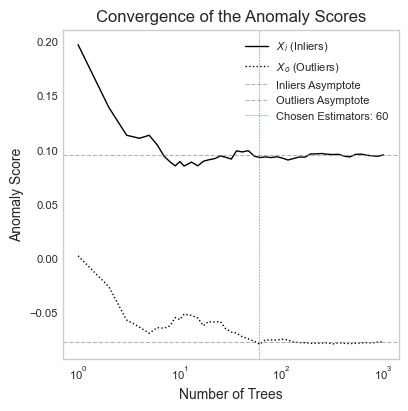

In [572]:
rfm_treatment_1_epsilon = dbscan_diagnostics(data=df_5, features=rfm_feats_treatment_1, target_noise_share=0.10, eps_range=dict(l_bound=0.01, u_bound=0.25, n_iter=20))
rfm_treatment_1_iforest_estimators = iforest_diagnostics(data=df_5, features=rfm_feats_treatment_1, choice_of_estimators=60)

In [573]:
df_5 = multivariate_outliers_clean(data=df_5, features=rfm_feats_treatment_1, outlier_column_label='rfm_feats_treatment_1_outliers', 
                                   dbscan_kws=dict(epsilon=rfm_treatment_1_epsilon), 
                                   iforest_kws=dict(chosen_n_trees=rfm_treatment_1_iforest_estimators, samplesize=0.002, contamination=0.1111))
                                       
                                       
df_5['rfm_feats_treatment_1_outliers'].value_counts(normalize=True)

rfm_feats_treatment_1_outliers
 1    0.602196
-1    0.397804
Name: proportion, dtype: float64

#### 3.2.1.2. RFM Treatment 2: Log and Standardization

In [574]:
rfm_feats_treatment_2 = [i + '_treatment_2' for i in rfm_feats]

df_5[rfm_feats_treatment_2] = StandardScaler().fit_transform(X=np.log1p(df_5[rfm_feats]))

df_5['rfm_feats_treatment_2_outliers'] = 0 # We create the column for the outlier labels

df_5.loc[  df_5['lifetime_treatment_2'] == df_5['lifetime_treatment_2'].min(), 'rfm_feats_treatment_2_outliers'] = -1 # We manually classify clients who consumed once as outliers to avoid centroid deviating too much towards this sporadic customers

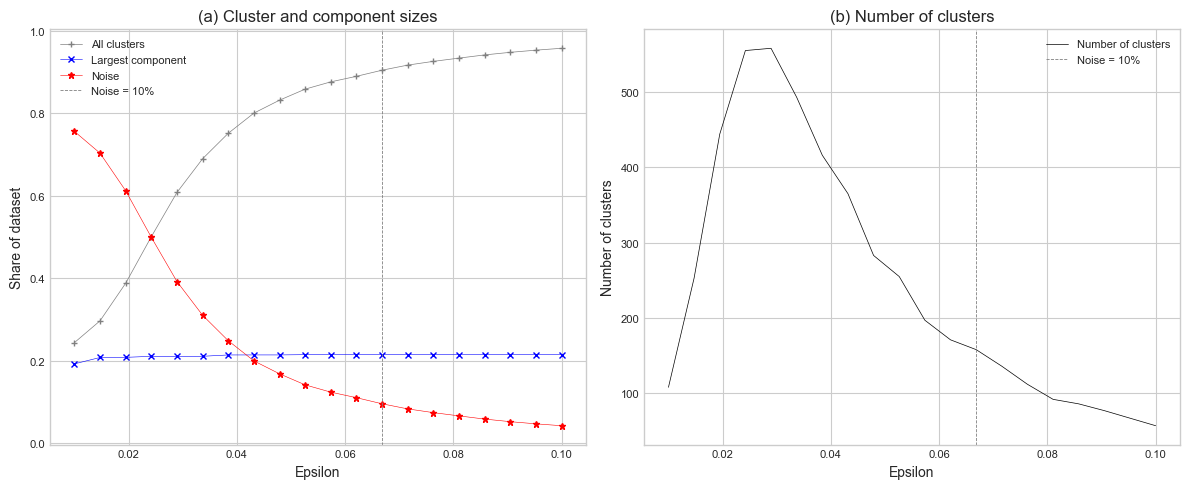

The epsilon which makes noise 10.0% of the data set is approximately: 0.0668


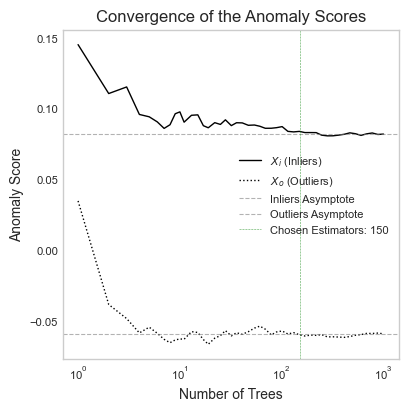

In [575]:
rfm_treatment_2_epsilon = dbscan_diagnostics(data=df_5, features=rfm_feats_treatment_2, target_noise_share=0.10, eps_range=dict(l_bound=0.01, u_bound=0.1, n_iter=20))
rfm_treatment_2_iforest_estimators = iforest_diagnostics(data=df_5, features=rfm_feats_treatment_2, choice_of_estimators=150)

In [576]:
df_5 = multivariate_outliers_clean(data=df_5, features=rfm_feats_treatment_2, outlier_column_label='rfm_feats_treatment_2_outliers', 
                                   dbscan_kws=dict(epsilon=rfm_treatment_2_epsilon), 
                                   iforest_kws=dict(chosen_n_trees=rfm_treatment_2_iforest_estimators, samplesize=0.002, contamination=0.1111))
                                       
                                       
df_5['rfm_feats_treatment_2_outliers'].value_counts(normalize=True)

rfm_feats_treatment_2_outliers
 1    0.601945
-1    0.398055
Name: proportion, dtype: float64

#### 3.2.1.3. RFM Treatment 3: Percentile scores (No need to standardize since all are on the same scale)

In [577]:
rfm_feats_treatment_3 = [i + '_treatment_3' for i in rfm_feats]

df_5[rfm_feats_treatment_3] = StandardScaler().fit_transform(df_5[rfm_feats].rank(pct=True))

df_5['rfm_feats_treatment_3_outliers'] = 0 # We create the column for the outlier labels

df_5.loc[df_5['lifetime'] == df_5['lifetime'].min(), 'rfm_feats_treatment_3_outliers' ] = -1

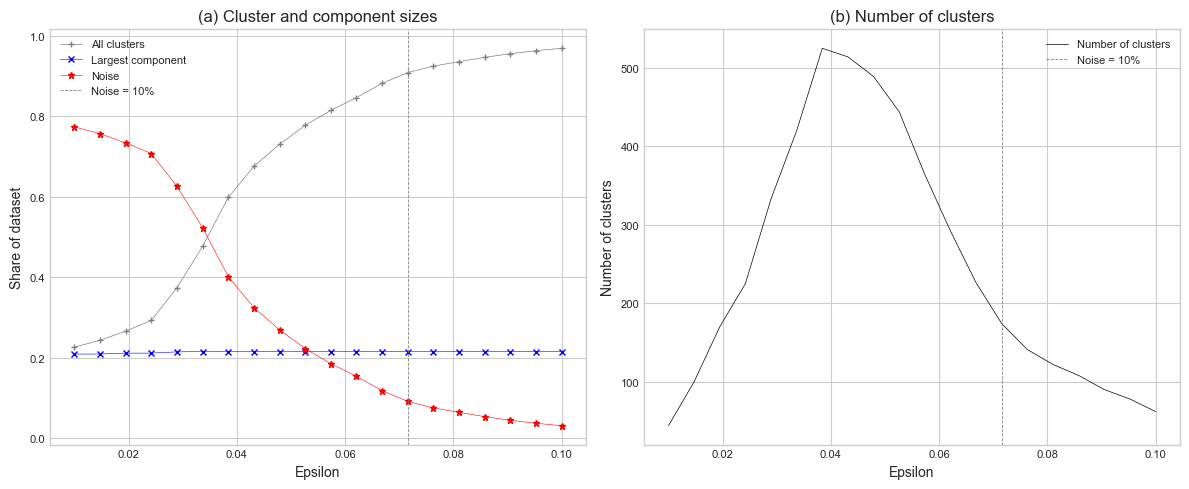

The epsilon which makes noise 10.0% of the data set is approximately: 0.0716


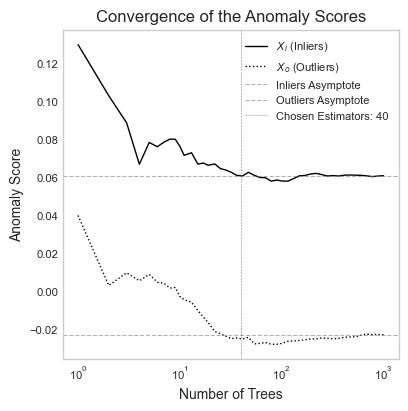

In [578]:
rfm_treatment_3_epsilon = dbscan_diagnostics(data=df_5, features=rfm_feats_treatment_3, target_noise_share=0.10, eps_range=dict(l_bound=0.01, u_bound=0.1, n_iter=20))
rfm_treatment_3_iforest_estimators = iforest_diagnostics(data=df_5, features=rfm_feats_treatment_3, choice_of_estimators=40)

In [579]:
df_5 = multivariate_outliers_clean(data=df_5, features=rfm_feats_treatment_3, outlier_column_label='rfm_feats_treatment_3_outliers', 
                                   dbscan_kws=dict(epsilon=rfm_treatment_3_epsilon), 
                                   iforest_kws=dict(chosen_n_trees=rfm_treatment_3_iforest_estimators, samplesize=0.002, contamination=0.1111))

### 3.2.2. Time Clustering 

In [580]:
df_6 = df_5.copy()


total_orders = df_6[hr_features].sum(axis=1)

df_6['workdays'] = (df_6[dow_features[1:6]].sum(axis=1)/total_orders)*df_6[cui_features].sum(axis=1)
df_6['weekend'] = (df_6[[dow_features[0], dow_features[-1]]].sum(axis=1)/total_orders)*df_6[cui_features].sum(axis=1)



df_6['lunch'] = (df_6[hr_features[8:14]].sum(axis=1)/total_orders)*df_6[cui_features].sum(axis=1)
df_6['dinner'] = (df_6[hr_features[16:21]].sum(axis=1)/total_orders)*df_6[cui_features].sum(axis=1)


time_feats = ['workdays', 'weekend', 'lunch', 'dinner']

df_6[time_feats] = df_6[time_feats].fillna(0)

#### 3.2.2.1. Time Treament 1: Barely any, but standardize

In [581]:
time_feats_treatment_1 = [i + '_treatment_1' for i in time_feats]

df_6[time_feats_treatment_1] = StandardScaler().fit_transform( df_6[time_feats] )

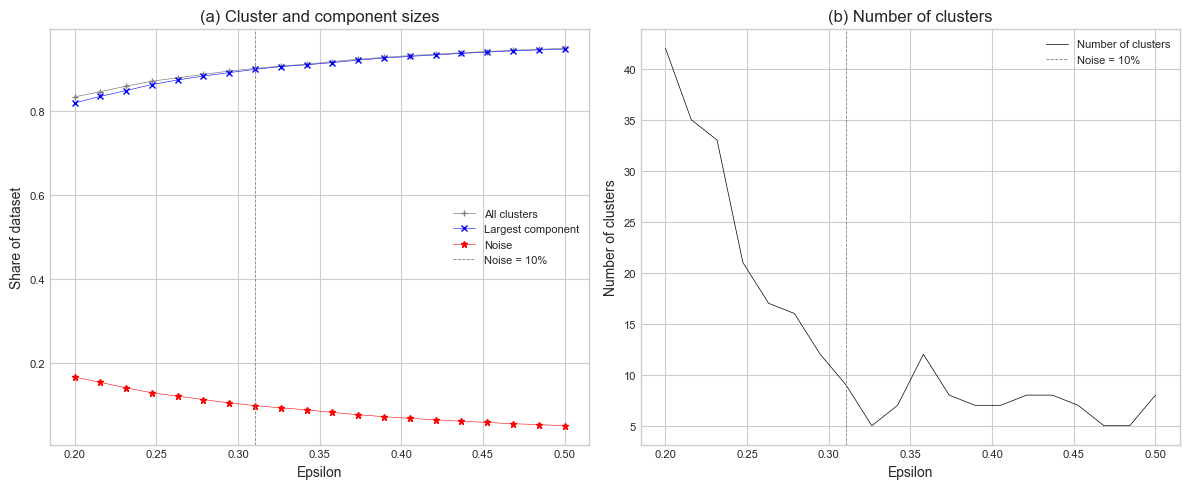

The epsilon which makes noise 10.0% of the data set is approximately: 0.3105


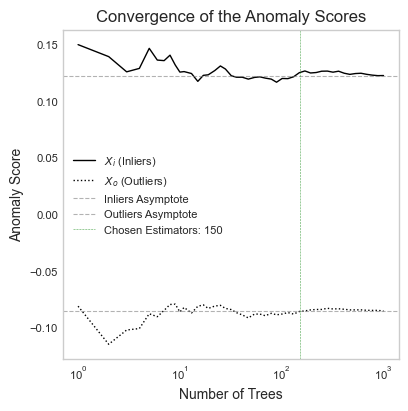

In [582]:
time_treatment_1_epsilon = dbscan_diagnostics(data=df_6, features=time_feats_treatment_1, target_noise_share=0.10, eps_range=dict(l_bound=0.2, u_bound=0.5, n_iter=20))
time_treatment_1_iforest_estimators = iforest_diagnostics(data=df_6, features=time_feats_treatment_1, choice_of_estimators=150)

In [583]:
df_6 = multivariate_outliers_clean(data=df_6, features=time_feats_treatment_1, outlier_column_label='time_feats_treatment_1_outliers', 
                                   dbscan_kws=dict(epsilon=time_treatment_1_epsilon), 
                                   iforest_kws=dict(chosen_n_trees=time_treatment_1_iforest_estimators, samplesize=0.002, contamination=0.1111))

In [584]:
df_6['time_feats_treatment_1_outliers'].value_counts(normalize=True)

time_feats_treatment_1_outliers
 1    0.802259
-1    0.197741
Name: proportion, dtype: float64

#### 3.2.2.1. Time Treament 2: Log and standardization

In [585]:
time_feats_treatment_2 = [i + '_treatment_2' for i in time_feats]

df_6[time_feats_treatment_2] = StandardScaler().fit_transform( np.log1p(df_6[time_feats]) )

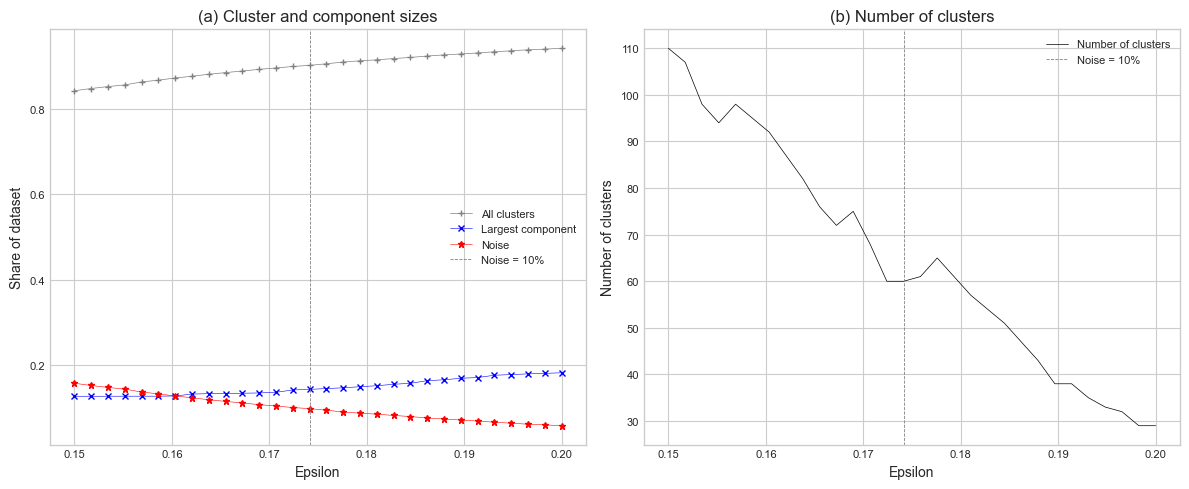

The epsilon which makes noise 10.0% of the data set is approximately: 0.1741


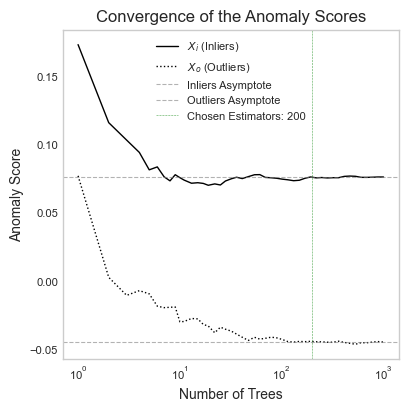

In [586]:
time_treatment_2_epsilon = dbscan_diagnostics(data=df_6, features=time_feats_treatment_2, target_noise_share=0.1, eps_range=dict(l_bound=0.15, u_bound=0.2, n_iter=30))
time_treatment_2_iforest_estimators = iforest_diagnostics(data=df_6, features=time_feats_treatment_2, choice_of_estimators=200)

In [587]:
df_6 = multivariate_outliers_clean(data=df_6, features=time_feats_treatment_2, outlier_column_label='time_feats_treatment_2_outliers', 
                                   dbscan_kws=dict(epsilon=time_treatment_2_epsilon), 
                                   iforest_kws=dict(chosen_n_trees=time_treatment_2_iforest_estimators, samplesize=0.002, contamination=0.1111))

df_6['time_feats_treatment_2_outliers'].value_counts(normalize=True).rename({1:'Inliers', -1:'outliers'})

time_feats_treatment_2_outliers
Inliers     0.801537
outliers    0.198463
Name: proportion, dtype: float64

#### 3.2.2.1. Time Treament 3: Percentile Scores

In [588]:
time_feats_treatment_3 = [i + '_treatment_3' for i in time_feats]

df_6[time_feats_treatment_3] = df_6[time_feats].rank(pct=True)

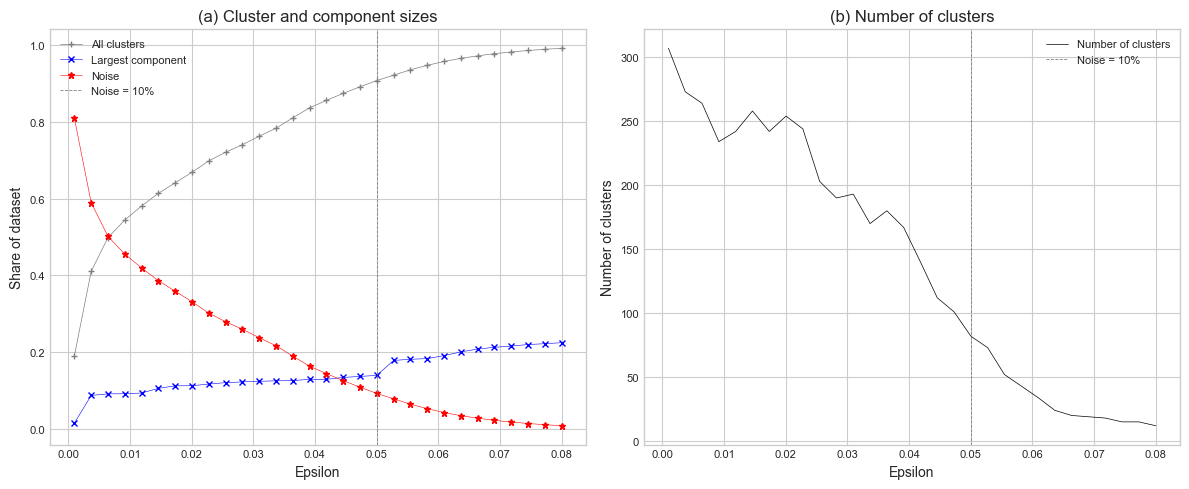

The epsilon which makes noise 10.0% of the data set is approximately: 0.05


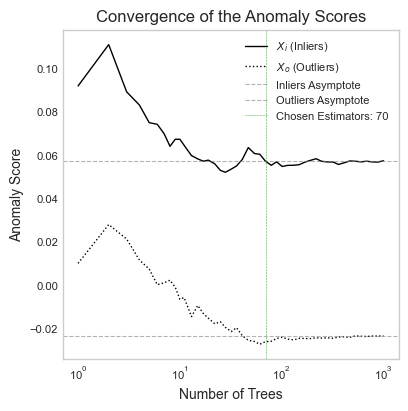

In [589]:
time_treatment_3_epsilon = dbscan_diagnostics(data=df_6, features=time_feats_treatment_3, target_noise_share=0.1, eps_range=dict(l_bound=0.001, u_bound=0.08, n_iter=30))
time_treatment_3_iforest_estimators = iforest_diagnostics(data=df_6, features=time_feats_treatment_3, choice_of_estimators=70)

In [590]:
df_6 = multivariate_outliers_clean(data=df_6, features=time_feats_treatment_3, outlier_column_label='time_feats_treatment_3_outliers', 
                                   dbscan_kws=dict(epsilon=time_treatment_3_epsilon), 
                                   iforest_kws=dict(chosen_n_trees=time_treatment_3_iforest_estimators, samplesize=0.002, contamination=0.1111))

df_6['time_feats_treatment_3_outliers'].value_counts(normalize=True)

time_feats_treatment_3_outliers
 1    0.807341
-1    0.192659
Name: proportion, dtype: float64

### 3.2.3. Cuisines: Diverse Customers Analysis

In [591]:
df_7 = df_6.copy()

cuisine_feats_treatment_1 = [i + '_treatment_1' for i in cui_features]

for cuisine, new_cuisine in zip(cui_features, cuisine_feats_treatment_1):
    df_7[new_cuisine] = df_7[cuisine]/df_7['monetary_value']

for cuisine in cuisine_feats_treatment_1:
    df_7[cuisine] = df_7[cuisine]*df_7['product_count']

chosen_cuisines = ['CUI_Asian_treatment_1', 'CUI_American_treatment_1', 'CUI_OTHER_treatment_1']

diverse_customers = df_7.loc[(df_7[chosen_cuisines].fillna(0) != 0).all(axis=1)]


diverse_customers[chosen_cuisines] = StandardScaler().fit_transform(np.log1p(diverse_customers[chosen_cuisines]))

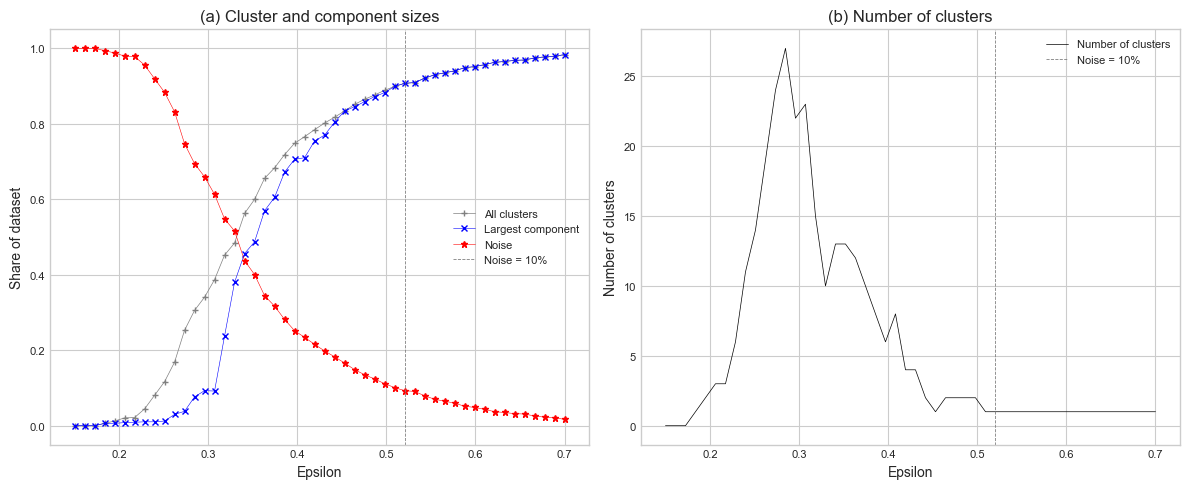

The epsilon which makes noise 10.0% of the data set is approximately: 0.5204


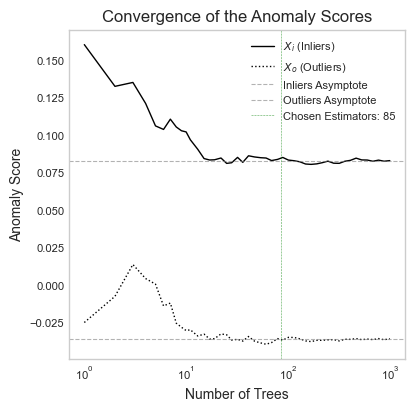

In [593]:
diverse_customers_epsilon = dbscan_diagnostics(data=diverse_customers, features=chosen_cuisines, target_noise_share=0.10, eps_range=dict(l_bound=0.15, u_bound=0.7, n_iter=50))
diverse_customers_iforest_estimators = iforest_diagnostics(data=diverse_customers, features=chosen_cuisines, choice_of_estimators=85)

In [594]:
diverse_customers = multivariate_outliers_clean(data=diverse_customers, features=chosen_cuisines, outlier_column_label='diverse_customers_outliers',
                                                dbscan_kws=dict(epsilon=diverse_customers_epsilon),
                                                iforest_kws=dict(chosen_n_trees=diverse_customers_iforest_estimators, samplesize=0.002, contamination=0.1111))

In [547]:
diverse_customers['diverse_customers_outliers'].value_counts(normalize=True)

diverse_customers_outliers
 1    0.904025
-1    0.095975
Name: proportion, dtype: float64

## 4. Data Export

In [598]:
df_7.to_csv('pre_processed_dataframe.csv', index=False)
diverse_customers.to_csv('diverse_customers.csv', index=False)

feats_lists = {'rfm': {'treatment_1':rfm_feats_treatment_1,
                      'treatment_2':rfm_feats_treatment_2,
                      'treatment_3':rfm_feats_treatment_3},
              'time': {'treatment_1':time_feats_treatment_1,
                      'treatment_2':time_feats_treatment_2,
                      'treatment_3':time_feats_treatment_3},
              'cuisines': {'treatment_1': chosen_cuisines}
              }


outlier_columns = {'rfm': {'treatment_1' : 'rfm_feats_treatment_1_outliers',
                           'treatment_2':'rfm_feats_treatment_2_outliers',
                           'treatment_3': 'rfm_feats_treatment_3_outliers'},
                   'time': {'treatment_1':'time_feats_treatment_1_outliers',
                            'treatment_2':'time_feats_treatment_2_outliers',
                            'treatment_3':'time_feats_treatment_3_outliers'},
                   'cuisines': {'treatment_1': 'diverse_customers_outliers'}
                   }

import json

with open('feats_lists.json', 'w') as file:
    json.dump(feats_lists, file)
    
with open('outlier_columns.json', 'w') as file:
    json.dump(outlier_columns, file)